**NAMA: Khairy Zhafhran H. Kastella**

**NIM: 202210370311439**

In [ ]:
import pandas as pd

df = pd.read_csv('/content/spam.csv', sep=';', engine='python', on_bad_lines='skip')
display(df.head())

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36
0,ham,Oh k...i'm watching here:),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ham,Eh u remember how 2 spell his name... Yes i di...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ham,Fine if that��s the way u feel. That��s the wa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ham,Yeah he got in at 2 and was v apologetic. n ha...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ham,K tell me anything about you.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = pd.read_csv("/content/spam.csv", encoding="latin-1", sep=';', engine='python', on_bad_lines='skip')

if df.shape[1] >= 2:
    df = df.iloc[:, :2]
elif df.shape[1] == 1:
    pass

df.columns = ['target', 'message']

df.head()

,target,message
0,ham,Oh k...i'm watching here:)
1,ham,Eh u remember how 2 spell his name... Yes i di...
2,ham,Fine if thatï¿½ï¿½s the way u feel. Thatï¿½ï¿½...
3,ham,Yeah he got in at 2 and was v apologetic. n ha...
4,ham,K tell me anything about you.


In [ ]:
df['message_len'] = df['message'].apply(lambda x: len(x.split(' ')) if isinstance(x, str) else 0)
df.head()

,target,message,message_len
0,ham,Oh k...i'm watching here:),4
1,ham,Eh u remember how 2 spell his name... Yes i di...,19
2,ham,Fine if thatï¿½ï¿½s the way u feel. Thatï¿½ï¿½...,13
3,ham,Yeah he got in at 2 and was v apologetic. n ha...,42
4,ham,K tell me anything about you.,6


In [ ]:
df.isnull().sum()


,0
target,0
message,4
message_len,0


In [ ]:
df.duplicated().sum()


np.int64(256)

In [ ]:
max(df['message_len'])


162

Epoch 1 | Loss: 0.3614 | Acc: 0.8799
Epoch 2 | Loss: 0.2035 | Acc: 0.9143
Epoch 3 | Loss: 0.1532 | Acc: 0.9530
Epoch 4 | Loss: 0.2145 | Acc: 0.9175
Epoch 5 | Loss: 0.1615 | Acc: 0.9377


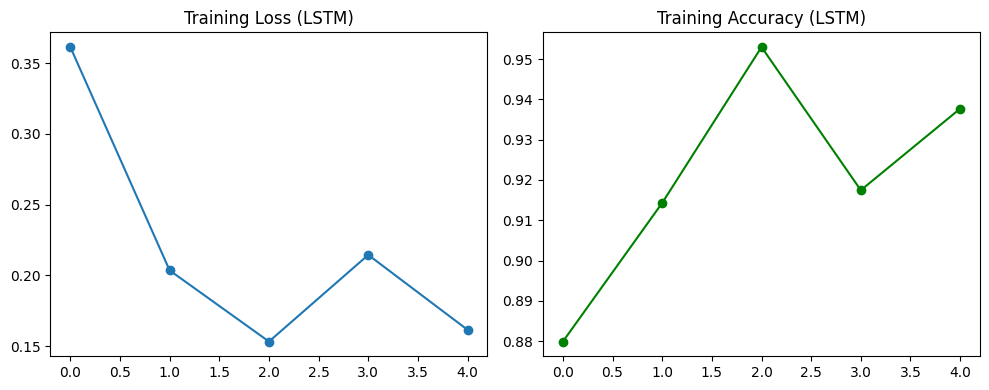

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import os

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from collections import Counter

# =========================
# LOAD DATA
# =========================
texts, labels = [], []

with open("/content/spam.csv", encoding="latin-1") as f:
    for line in f:
        parts = line.strip().split(";", 1)
        if len(parts) == 2 and parts[0] in ["ham", "spam"]:
            texts.append(parts[1])
            labels.append(parts[0])

df = pd.DataFrame({"text": texts, "label": labels})

le = LabelEncoder()
df["label"] = le.fit_transform(df["label"])  # ham=0, spam=1

# =========================
# TOKENIZATION (MANUAL)
# =========================
def tokenize(text):
    return text.lower().split()

tokenized = [tokenize(t) for t in df["text"]]

word_counts = Counter(w for sent in tokenized for w in sent)
vocab = {w: i+2 for i, (w, _) in enumerate(word_counts.most_common(5000))}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

def encode(sentence, max_len=50):
    encoded = [vocab.get(w, 1) for w in sentence][:max_len]
    return encoded + [0] * (max_len - len(encoded))

X = torch.tensor([encode(s) for s in tokenized])
y = torch.tensor(df["label"].values)

# =========================
# SPLIT DATA
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =========================
# DATASET
# =========================
class SpamDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(SpamDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(SpamDataset(X_test, y_test), batch_size=32)

# =========================
# LSTM MODEL
# =========================
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (h, _) = self.lstm(x)
        return self.sigmoid(self.fc(h[-1])).squeeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(len(vocab)).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# =========================
# TRAINING
# =========================
EPOCHS = 5
train_losses, train_accs = [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.float().to(device)
        optimizer.zero_grad()

        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += ((preds > 0.5) == yb).sum().item()
        total += yb.size(0)

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(correct / total)

    print(f"Epoch {epoch+1} | Loss: {train_losses[-1]:.4f} | Acc: {train_accs[-1]:.4f}")

# =========================
# SAVE MODEL
# =========================
os.makedirs("model_lstm", exist_ok=True)
torch.save(model.state_dict(), "model_lstm/model_lstm.pt")
torch.save(vocab, "model_lstm/vocab.pt")

# =========================
# PLOT LOSS & ACCURACY
# =========================
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_losses, marker='o')
plt.title("Training Loss (LSTM)")

plt.subplot(1,2,2)
plt.plot(train_accs, marker='o', color='green')
plt.title("Training Accuracy (LSTM)")

plt.tight_layout()
plt.show()


=== Classification Report (LSTM) ===
              precision    recall  f1-score   support

         HAM       0.96      1.00      0.98      4814
        SPAM       0.97      0.72      0.83       744

    accuracy                           0.96      5558
   macro avg       0.97      0.86      0.90      5558
weighted avg       0.96      0.96      0.96      5558



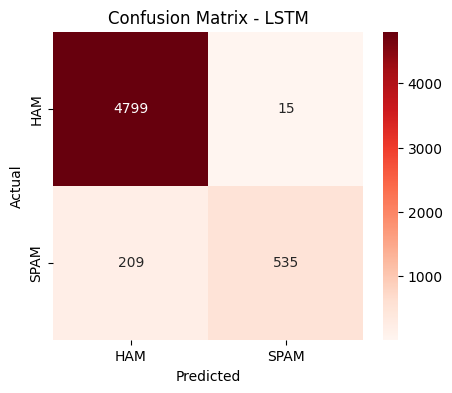

In [5]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# =========================
# KONFIGURASI
# =========================
MAX_LEN = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================
# LOAD VOCAB & MODEL
# =========================
vocab = torch.load("model_lstm/vocab.pt")

# The LSTMClassifier class is defined in cell 3qLlu1pKhuUm and is already in scope.
# from train_lstm import LSTMClassifier # This line caused the error.
model = LSTMClassifier(len(vocab))
model.load_state_dict(torch.load("model_lstm/model_lstm.pt", map_location=device))
model.to(device)
model.eval()

# =========================
# LOAD DATA
# =========================
texts, labels = [], []

with open("/content/spam.csv", encoding="latin-1") as f:
    for line in f:
        parts = line.strip().split(";", 1)
        if len(parts) == 2 and parts[0] in ["ham", "spam"]:
            texts.append(parts[1])
            labels.append(0 if parts[0] == "ham" else 1)

# =========================
# ENCODING (FIXED LENGTH)
# =========================
def encode(sentence):
    tokens = sentence.lower().split()
    encoded = [vocab.get(w, 1) for w in tokens][:MAX_LEN]
    padded = encoded + [0] * (MAX_LEN - len(encoded))
    return padded

X = torch.tensor([encode(t) for t in texts]).to(device)
y = torch.tensor(labels)

# =========================
# PREDICTION
# =========================
with torch.no_grad():
    outputs = model(X)
    preds = (outputs > 0.5).int().cpu().numpy()

# =========================
# CLASSIFICATION REPORT
# =========================
print("\n=== Classification Report (LSTM) ===")
print(classification_report(y, preds, target_names=["HAM", "SPAM"]))

# =========================
# CONFUSION MATRIX
# =========================
cm = confusion_matrix(y, preds)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Reds",
    xticklabels=["HAM", "SPAM"],
    yticklabels=["HAM", "SPAM"]
)
plt.title("Confusion Matrix - LSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
